In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
# colors used
# colors used
import scipy.linalg

ORANGE_SCALE = ['#FFC999','#FFA04D','#FF7803']
NEW_SCALE = ['#FF9132','#008F00','#8A2BE2']
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 8
FIG_HEIGHT = 4

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_temp = np.convolve(y, box, mode='valid')
    added_len = len(y)-len(y_temp)
    if added_len%2 == 0:
        pads = [added_len//2,added_len//2]
    else:
        pads = [(added_len//2)+1,added_len//2]
    y_smooth = np.concatenate((np.ones(pads[0])*y_temp[0],y_temp,y_temp[-1]*np.ones(pads[1])))
    return y_smooth


In [2]:
# Lets load in some of the simulations from the two lane road
sim_dir = {'2':'/media/mark/Ubuntu/results/new_drone/2_lane/',
           '3':'/media/mark/Ubuntu/results/new_drone/3_lane/',
           '4':'/media/mark/Ubuntu/results/new_drone/4_lane/'}
SAVE_PATHS = {'2':'/home/mark/Documents/code/drone/sumo/results/2_lane/',
              '3':'/home/mark/Documents/code/drone/sumo/results/3_lane/',
              '4':'/home/mark/Documents/code/drone/sumo/results/4_lane/'}

FINAL_SAVE = '/home/mark/Documents/latex/Drone_transC/figures/'

keys = ['2','3','4']
axs_key = {'2':0,'3':1,'4':2}
ratio_title ={'2':'Two Lane Road','3':'Three Lane Road','4':'Four Lane Road'}
flows_dic = {'2':np.arange(0,3000,10),
         '3':np.arange(0,4500,10),
         '4':np.arange(0,6000,10)}
         
ratios = np.logspace(np.log10(0.001),np.log10(0.1),100)

ffl = {'2': 0.687756692400056, '3': 2.6141339196535847, '4': 3.8939236495946394}
base_caps = {'2': 2670, '3': 4040, '4': 5300}
sub_caps = {'2': 270, '3': 410, '4': 530}

[15.75812964  0.02109056]
r2:  0.8025251237044937
[4.26392855 0.06173418]
r2:  0.7556000038885109
[1.91730372 0.05962975]
r2:  0.8196088931159736


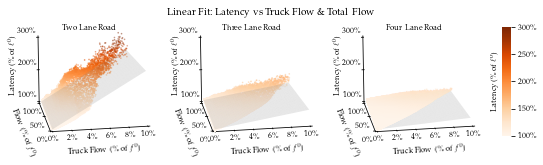

In [3]:
from matplotlib import colors
import matplotlib.ticker as mtick

FIGW = 7.4
FIGH = 2.2

CBAR_H = 0.7
CBAR_W = 0.018

C_MIN = 1
C_MAX = 3

# XLIM = {'2': 2700, '3': 410, '4': 530}
CUTOFF = 0.1

fig = plt.figure(figsize=(FIGW,FIGH))
widths = [(1-CBAR_W)/3,(1-CBAR_W)/3,(1-CBAR_W)/3,CBAR_W]
heights = [(1-CBAR_H)/2,CBAR_H,(1-CBAR_H)/2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                        height_ratios=heights,
                        left=0.02,
                        bottom=0.02,
                        right=0.95,
                        top=1)
spec.update(wspace=0.11, hspace=0)

fig.suptitle('Linear Fit: Latency vs Truck Flow \\& Total Flow', fontsize=10)
ax_color = fig.add_subplot(spec[1,-1])
for key in ['2','3','4']:
    # First two lane
    D = pickle.load(open(SAVE_PATHS[key]+'latency.p','rb'))
    l = D['l']
    ratios = D['ratios']
    flows =  D['flows'] 
    flows_fit = flows_dic[key]
    # pre-process
    data = []
    other_x = []
    for r_idx in range(100):
        # for f_idx in range(l.shape[1]):
        for f_idx in range(base_caps[key]//10-1):
            if l[r_idx,f_idx]<CUTOFF:
                pass
            else:
                x = (flows[f_idx]*ratios[r_idx])/base_caps[key]
                y = flows[f_idx]/base_caps[key]
                z = l[r_idx,f_idx]/ffl[key]
                data.append([x,y,z])

    data = np.asarray(data)
    # # CREATE LINEAR FIT
    # # regular grid covering the domain of the data
    X,Y = np.meshgrid(flows_fit[0:sub_caps[key]//10]/base_caps[key], flows_fit[0:base_caps[key]//10]/base_caps[key])
    XX = X.flatten()
    YY = Y.flatten()

    A_lin = np.c_[data[:,0], data[:,1]]
    # ffls = np.ones(data.shape[0])*ffl[key]
    C_lin,_,_,_ = scipy.linalg.lstsq(A_lin, data[:,2]-1)    # coefficients
    
    Z = np.dot(np.c_[XX, YY], C_lin).reshape(X.shape) + 1
    print(C_lin)
    # break
    # Compute error
    error = []
    for point in data:
        estimate =  np.dot(C_lin,[point[0],point[1]]) + 1
        error.append((point[2])-estimate)
    error = np.asarray(error)
    r2 = 1-(error.var()/data[:,2].var())
    print('r2: ',r2)

    #------------------------------------------------------------------#
    # PLOT
    #------------------------------------------------------------------#
    axs = fig.add_subplot(spec[:,axs_key[key]],projection='3d')
    axs.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
    axs.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axs.zaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    axs.set_title(ratio_title[key],y=1.0,pad=-12,fontsize=8)
    # if key == '2':
    axs.set_zlabel('Latency ($\\%$ of $\\ell^0$)',rotation=90,labelpad=0)
    axs.set_ylabel('Flow ($\\%$ of $f^0$)',labelpad=-4)

    axs.set_xlabel('Truck Flow ($\\%$ of $f^0$)',labelpad=-6)
    axs.zaxis.set_rotate_label(False)
    # make the everything transparent
    axs.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axs.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axs.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # axs.grid('off')
    axs.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    axs.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    axs.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # scatter original data

    sample_skip = 1
    data_len = data[:,0].shape[0]

    cmap = plt.cm.Oranges
    axs.plot_surface(X, Y, Z, color=GRAY, alpha=0.2, shade=True)
    points = axs.scatter(data[0:data_len:sample_skip,0], data[0:data_len:sample_skip,1], data[0:data_len:sample_skip,2], s=0.5,cmap = cmap,c=data[0:data_len:sample_skip,2], vmin=C_MIN, vmax=C_MAX)


    # axs.plot_surface(surf_x, surf_y, surf_z, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

    # before plotting surface, we want X to get transformed to ratios not flows

    # norm = colors.Normalize(X.min(), X.max())
    # c = plt.cm.ScalarMappable(norm=norm, cmap='Greys')
    # c.set_array([])

    # break
    # set up the limits and view
    axs.view_init(elev=15, azim=-100)
    # ax = fig.gca(projection='3d')
    axs.set_xlim([0,0.1])
    axs.set_ylim([0,1])
    axs.set_zlim([1,np.max(Z)])
    # deal with setting tickmarks 
    axs.tick_params(axis='x',pad=-5)
    axs.tick_params(axis='y',pad=-2,labelrotation=0)
    axs.tick_params(axis='z',pad=1)
    axs.set_xticks(np.array([0,0.02,0.04,0.06,0.08,.1]))
    axs.set_yticks(np.array([0,0.5,1]))
    axs.set_zticks(np.array([1,2,3]))
    # axs.set_zticklabels(['$\\frac{1}{2}$','$1$','$\\frac{3}{2}$','$2$'])
    axs.zaxis.set_ticks_position("top")
    # break

    # if key != '2':
    #     axs.set_yticklabels([])
    #     axs.set_zticklabels([])


# SAVING CODE #
# # colorbar
# clim = np.maximum(abs(np.min(error)),np.max(error))
# print(np.min(data[:,2]),np.max(data[:,2]))
# points.set_clim(np.min(data[:,2]),np.max(data[:,2]))
cb = plt.colorbar(points,cax=ax_color)
ax_color.set_ylabel('Latency ($\\%$ of $\\ell^0$)')
ax_color.yaxis.set_label_position("left")
cb.outline.set_visible(False)
cb.set_ticks([1,1.5,2,2.5,3])
cb.set_ticklabels(['$100 \\%$','$150 \\%$','$200 \\%$','$250 \\%$','$300 \\%$'])
bbox = mpl.transforms.Bbox([[0,0],[FIGW,FIGH]])
plt.savefig(FINAL_SAVE+'sumo_lat3d'+ '.pdf',bbox_inches=bbox)
plt.savefig(FINAL_SAVE+'sumo_lat3d'+ '.png',bbox_inches=bbox)


